# Data Exploration

This dataset consisits of 64x64 images captured by Sentinel-2A satellite and it has over 27000 images spread across 10 classes. Originally the data consists of hyperspectral images with 13 spectral bands but we will be working with only RGB channels

The dataset is omposed of images taken from the Sentinel-2 satellite. It lists images of the earth's surface into 10 different land cover labels. 

In [1]:
# importing libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset = "./dataset"
labels = os.listdir(dataset)
labels

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

These are the 10 classes of land cover in the dataset.

### Plotting class distributions of dataset

Text(0.5, 1.0, 'EUROSAT Class Distribution')

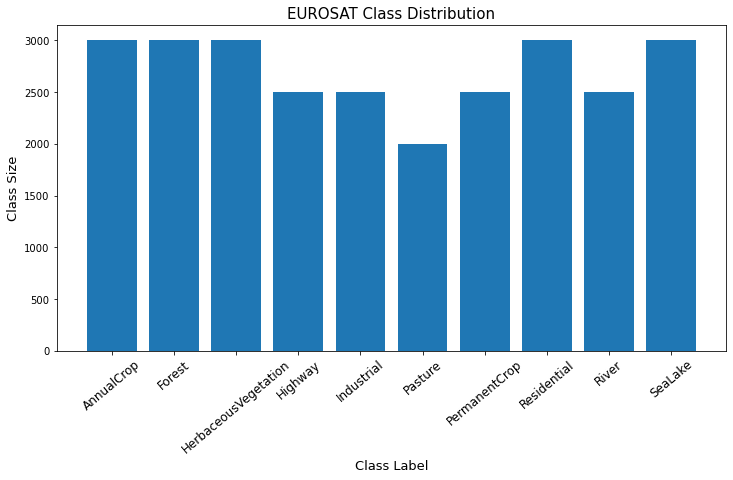

In [3]:
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(dataset, l)))

plt.figure(figsize=(12,6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('Class Label', fontsize=13)
plt.ylabel('Class Size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15)

The dataset is split into 10 classes of land cover. Each class varies in size, so we will have to stratify later on (when splitting the data into training, testing and validation sets).

### Preview of Different Classes

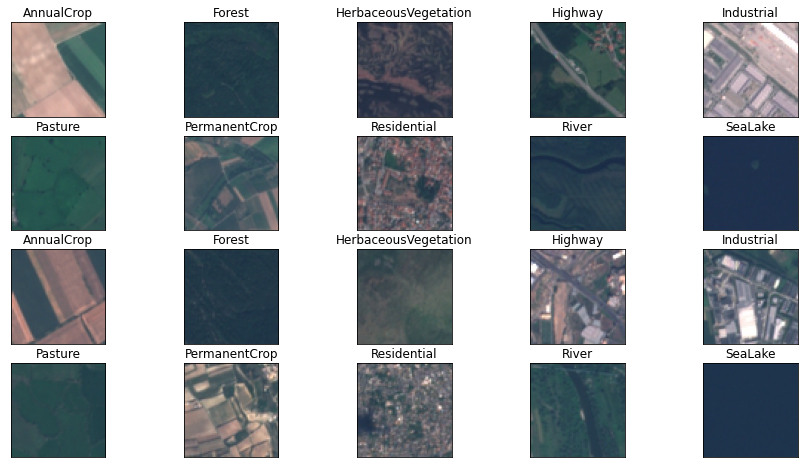

In [4]:
img_paths = [os.path.join(dataset, l, l+'_1000.jpg') for l in labels]

img_paths = img_paths + [os.path.join(dataset, l, l+'_2000.jpg') for l in labels]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('\\')[-2])

plot_sat_imgs(img_paths)

1. Some similarities and differences between the classes are observed.
2. Urban environments such as Highway, Residential, Industrial images contain structures and some roadways.
3. AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields.
4. HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data.

# Data Preprocessing

We have performed a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. We will be loading my data into the Keras model using the ImageDataGenerator class. We will need the images to be in their own respective land cover directories.

After splitting the dataset, we will create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training.

In [3]:
# importing libraries
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [4]:
TRAIN_DIR = './working/training'
TEST_DIR = './working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(labels)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

In [7]:
# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

In [8]:
# create class label subdirectories in train and test
for l in labels:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [9]:
# map each image path to their class label in 'data'
data = {}

for l in labels:
    for img in os.listdir(dataset+'/'+l):
        data.update({os.path.join(dataset, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

In [10]:
split

StratifiedShuffleSplit(n_splits=1, random_state=69, test_size=0.2,
            train_size=None)

In [11]:
# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('\.\/dataset', './working/training', i) for i in train_paths]
    new_test_paths = [re.sub('\.\/dataset', './working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  0%|                                                                                        | 0/21600 [00:00<?, ?it/s]

moving training files..


  0%|                                                                                 | 8/5400 [00:00<01:07, 79.74it/s]

moving testing files..


100%|████████████████████████████████████████████████████████████████████████████| 5400/5400 [00:04<00:00, 1126.37it/s]


In [5]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [6]:
print(train_generator.class_indices)
np.save('class_indices', train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


# Machine Learning for Image Classification

We will see how a machine learning model performs by directly feeding it the whole image pixels (64x64x3 = 12288). From our 80-20 split on the 27000 samples dataset the training data is of size 21600 and test data is of size 5400. Now, here we will use some trick to utilize keras ImageDataGenerator such that we can obtain the image dataset as a numpy array which can be used by a machine learning model for training and testing.

In [7]:
# Using image data generator api in keras for making image dataset 
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    # by using batch_size as training data size we can extract data from this iterator
    batch_size=21600, 
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=7
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [8]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

#### Random Forest

In [20]:
# Creating mini batches of training data as training on whole data is difficult
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [21]:
# import random forest classifier
from sklearn import ensemble
from sklearn.metrics import accuracy_score


rf_clf = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=7)
rf_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.6231


#### Extremely Randomized Trees

In [26]:
et_clf = ensemble.ExtraTreesClassifier(n_estimators=20, max_depth=None, min_samples_split=2, random_state=7, n_jobs=-1)
et_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = et_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.6289


#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=0)
dt_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = dt_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

#### Support Vector Machine (SVM) - Classification

In [ ]:
from sklearn import svm

svm_clf = svm.SVC(kernel = "linear")
svm_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = svm_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

# Deep Learning for Image Classification
Deep Learning has highly influenced the field of computer vision when Convolutional Neural Networks (CNN) models were used in tasks like image classification, object detection, facial recognition etc. As discussed by authors of EuroSAT paper many deep learning models outperform the traditional non deep learning methods by a large margin.

The CNN part of the model will be frozen with imagenet weights and dense layers will be trained with a high learning rate of 0.01 and later we will train the whole model end-to-end i.e. fine tune by keeping a small learning rate between 0.001 to 0.0001

Before we start here is a list of CNN models which we will train:

1. ResNet50
2. ResNet50V2
3. ResNet152V2
4. VGG16
5. VGG19

In [6]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [7]:
gpus = tf.config.experimental.list_physical_devices('XLA_GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

In [8]:
gpus

[]

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)